In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

<img src='data/public_bike_1.png' style ='width : 800px; height : 500px; text-align : center'>

출처 : https://m.blog.naver.com/noobin/221440806108

* 따릉이 무게 18kg

사례 1
* 편도 40km 거리를 로드바이크로 출퇴근 하는 사람
* 실험 차원에서 따릉이를 이용
* 시속 20km

사례 2
* 따릉이를 가지고 100km를 운행한 사람
* 시속 23.5km

결론
* 1시간에 24km는 허용가능한 오차로 인식
* 10분당 4km까지 허용가능한 범위라 생각
* 1분당 400미터 이상은 오류
* 아웃라이어 기준 =   $\large\frac{dist}{(riding\;time)}$ > 400  인 경우 


### 따릉이 학대범 기준
* 편도 22km(여의도한강공원-광나루 한강공원)를 1시간 내외로 돌파한 경우
<img src='data/public_bike_2.png' style ='width : 800px; height : 500px; text-align : center'>

In [5]:
#불러오기
seoul_bike = pd.read_hdf('D:\git_local_repository\data_for_project\seoul_bike\preprocessed_bike_1_2.hdf5')



# 1분당 거리 계산 (1분당 400미터 이상인 경우 error로 간주)
seoul_bike['m_pm'] = (seoul_bike['dist'] / (seoul_bike['riding_time'])).round(decimals=0)  # 1분당 거리 계산

station = pd.read_csv('D:\git_local_repository\data_for_project\seoul_bike\seoul_bike_station_01_12.csv',encoding='CP949')
station.rename(columns={'대여소 번호' : 'id'}, inplace=True)


#plotly continuous_color
continuous_color = pd.read_csv('data/plotly_continuous_color_codes.csv')

In [6]:
station = pd.read_csv('D:\git_local_repository\data_for_project\seoul_bike\seoul_bike_station_01_12.csv',encoding='CP949',index_col=0)
station.rename(columns={'대여소 번호' : 'id'}, inplace=True)

### 속도왕 분포현황

In [7]:


def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    m = 6367 * c * 1000
    return m

asd = station.query('id ==[766,755]')
haversine_np(asd.iloc[0,-3],asd.iloc[0,-2],asd.iloc[1,-3],asd.iloc[1,-2])
# station[station['주소2'].str.contains("월촌중")]

472.85728574452

In [8]:
#한국에는 자전거에 미친놈들이 많은건가 아니면이게 다 오류인가
# 선수급도 50km/h 속도가 나온다. 1분에 830미터 정도 달리는 거리다.
# 동호회 수준에서도 30km/h면 수준급 실력이라 한다. 1분에 500m 정도
# 4745948, 도심 한가운데서 분당 1km의 속도로 54키로를 달리는게 말이되나.. 54km면 여의도 공원 => 잠원 한강공원을 왕복하고도 한 번 더가야한다.
# 이게 말이되나.. 
sorted_seoul_bike = seoul_bike[seoul_bike.eval('m_pm >=450 ')].sort_values(by='m_pm',ascending=False)


In [ ]:
### 따릉이로 집주변 여행지 찾기 

In [84]:
# 1시간 내외로 갈만한 곳 찾기
# 766,754 기록을 가지고 찾아보는거야!!!

def searching_location(wanting_ids,min_time=1,max_time=60,num_of_times=20) : 
    sorted_st_id2=seoul_bike.query('st_id1 == @wanting_ids')['st_id2'].value_counts()
    sorted_st_id2= sorted_st_id2[~np.isin(sorted_st_id2.index,wanting_ids)]
    la_num=np.where(sorted_st_id2 >= num_of_times)[0][-1]
    result_station = []
    for station_id in sorted_st_id2[:la_num].index : 
        filter_id = seoul_bike.query('st_id1 == @wanting_ids & st_id2 == @station_id & @min_time <= riding_time <= @max_time').sort_values(by='riding_time')['riding_time'].value_counts().sort_values(ascending=False)
        mean = filter_id.index[:5].values.mean()
        percent = round(sum(filter_id[:5].values)/sum(filter_id),2)
        total_num = sum(filter_id)
        result_station.append([station_id,mean,percent,total_num])

    return pd.DataFrame(result_station,columns=['id','est_time','percent','total_num'])




In [11]:
station[station['주소2'].str.contains("을지로입구")]

,id,주소2,주소1,지역,위도,경도,설치일
187,320,을지로입구역 4번출구 앞,서울특별시 중구 을지로 55,중구,37.566223,126.983589,2015-10-07
281,433,을지로입구역 2번출구,중구 을지로1가 118,중구,37.566345,126.982292,2018-12-14
2489,4774,을지로입구역 8번출구,을지로1가 140-1,중구,37.565903,126.981781,2020-09-23


In [86]:
## 따릉이로 생활권 분리를 확인할 수 있으려나?

# 배터리 기준 : 1분 48초(549개) => 32초 (127개)

# 을지로 4가
wanting_ids = [389,473]
result_station_df = searching_location(wanting_ids,)
result_station_df.sort_values(by='total_num',ascending=False).head(10)

#을지로 입구
wanting_ids_left = [320,433,4774]
result_station_left = searching_location(wanting_ids)
result_station_left.sort_values(by='total_num',ascending=False).head(10)

,id,est_time,percent,total_num
0,4792,4.0,0.77,591
1,3413,6.0,0.88,524
2,398,4.0,0.61,350
3,345,7.0,0.88,239
4,338,4.0,0.87,228
5,380,4.0,0.64,198
6,390,6.2,0.66,191
7,329,6.0,0.73,180
8,387,5.0,0.65,150
9,368,9.0,0.68,148


In [100]:
import plotly.graph_objects as go 
# sort_1 = result_station_df.query('est_time > 45').sort_values(by='total_num',ascending=False)
sort_1 = result_station_df.sort_values(by='total_num',ascending=False)
sort_1 = sort_1.merge(station,on='id').query('0 < est_time <= 60 & total_num >= 50')

sort_2 = result_station_left.sort_values(by='total_num',ascending=False)
sort_2 = sort_2.merge(station,on='id').query('0 < est_time <= 60 & total_num >= 50')

fig = px.density_mapbox(sort_1, lat="위도", lon="경도",z='total_num',hover_name='주소2',hover_data=['id','주소2','total_num'],radius=10,color_continuous_scale='temps' ,zoom=13)
# fig_2 = px.density_mapbox(sort_2, lat="위도", lon="경도",z='est_time',hover_name='est_time',hover_data=['id','주소2','total_num'],radius=10,color_continuous_scale='bupu' ,zoom=10)
fig_3 = px.scatter_mapbox(station.query('id==@wanting_ids'), lat="위도", lon="경도", hover_name="주소2", hover_data=['id'],
                        color_continuous_scale='orangered', opacity=1)
# fig.add_trace(fig_2.data[0])
fig.add_trace(fig_3.data[0])
fig.show()

fig_2 = px.density_mapbox(sort_2, lat="위도", lon="경도",z='total_num',hover_name='주소2',hover_data=['id','주소2','total_num'],radius=10,color_continuous_scale='algae' ,zoom=13)
fig_3 = px.scatter_mapbox(station.query('id==@wanting_ids_left'), lat="위도", lon="경도", hover_name="주소2", hover_data=['id'],
                        color_continuous_scale='orangered', opacity=1)
fig_2.add_trace(fig_3.data[0])
fig_2.update_layout(mapbox_style="carto-positron")

fig_2.show()

(array([  0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

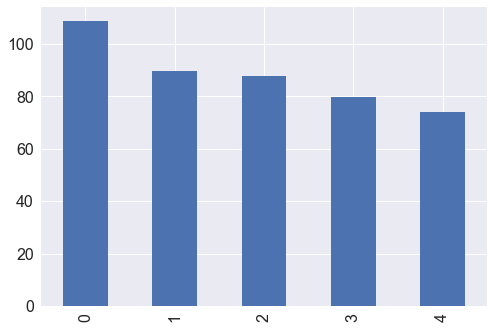

In [309]:
plt.style.use('seaborn')
a = sorted_seoul_bike.sort_values(by='dist',ascending=False)[:5]
a_dist = (a['dist']/1000).reset_index(drop=True).plot.bar()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# for i in range(5) : 
#     a_riding = a['riding_time'].values[i]
#     plt.text(-0.2+1*i, 105, a_riding)

### 속도왕 거주지

In [ ]:

# 나처럼 편도로 이용하는 경우도 있고
# 같거나 비슷한 거리에 있는 장소에서 반납하는 경우도 있음

a = seoul_bike.query('dist > 20000').groupby(['st_id1','st_id2']).size().sort_values(ascending=False).reset_index()
a.rename(columns={0:'대여횟수'},inplace=True)

#merge
merge_1 = pd.merge(a,station, how='inner', left_on='st_id1',right_on='id')
station_name = pd.merge(merge_1,station, how='inner', left_on='st_id2',right_on='id')

# 필요 없는값 제거 및 대여횟수별 정리
station_name.drop(columns=['st_id1','st_id2'],inplace=True)
station_name.sort_values(by='대여횟수',ascending=False)

BM = station_name['주소2_x'] != station_name['주소2_y']
values = station_name[BM].sort_values(by='대여횟수',ascending=False)

### 가장 많이 학대 당한 자전거는?

In [19]:
seoul_bike.query('dist >20000 & riding_time < 70').groupby('by_id').size().sort_values(ascending=False).head(10)

by_id
48728    12
45125     8
48001     8
57709     5
48541     4
57873     4
49422     4
58127     3
32142     3
49218     3
dtype: int64

### 가장 많은 거리를 달린 자전거는?

In [20]:
(seoul_bike.groupby('by_id')['dist'].sum()/1000).sort_values(ascending=False).head(10)

by_id
55341    4712.66000
48375    4577.22000
52721    4541.66417
46568    4467.42000
48361    4425.97000
49003    4391.18000
54374    4385.41000
49138    4361.05000
55624    4351.21000
55198    4339.55000
Name: dist, dtype: float64

### 오래 달린 자전거의 운행 기록은?

In [21]:
# 우리 55341 바이크는요.. 7~12월 총 1480번을 빌려졌어요. 평균 27분정도 빌려졌고 주행의 절반정도는 1860m이상을 운행했어요. 상위 10%운행은 7.8km를 달렸네요

seoul_bike.query('by_id==55341')
print(seoul_bike.query('by_id==55341')['riding_time'].mean())
print(seoul_bike.query('by_id==55341')['dist'].median())
print(seoul_bike.query('by_id==55341')['dist'].quantile(0.9))

27.333108108108107
1860.0
7783.000000000004


### 내 집 주위에 사는 사람들은 주로 어디를 이동할까? 
* 목동 754,4526,744,766 을지로 473, 389

In [104]:
where_to_go

,횟수,dest_id,id,주소2,주소1,지역,위도,경도,설치일
0,3091,521,744,신목동역 2번 출구,서울특별시 양천구 목동중앙로 212 앞,양천구,37.543842,126.882545,2020-10-28
1,2024,540,766,신목동역 3번출구,양천구 목동 136-1,양천구,37.544260,126.883250,2019-03-12
2,1787,529,754,목동1단지아파트 118동 앞 (월촌초등학교 정류소 옆,양천구 목동서로 38,양천구,37.541142,126.876678,2018-09-27
3,1230,530,755,목동1단지아파트 상가 앞 (월촌중학교 버스정류소 옆),양천구 목동서로 38,양천구,37.537868,126.881409,2018-09-27
4,989,2383,4526,목동아파트2단지 222동 앞,양천구 목동중앙로 125건너편,양천구,37.539688,126.874985,2021-04-06
...,...,...,...,...,...,...,...,...,...
569,1,1294,1846,롯데캐슬골드파크1차 동문,서울특별시 금천구 독산동 441-19,금천구,37.460171,126.896042,2017-11-01
570,1,293,446,상명대입구,서울특별시 종로구 홍지문길 1,종로구,37.600128,126.957832,2017-08-01
571,1,1912,3203,도림동배드민턴체육관,영등포구 도림동 276-2,영등포구,37.506115,126.898590,2020-03-04
572,1,796,1113,서남환경공원 버스정류장,서울특별시 강서구 양천로 201,강서구,37.573093,126.822899,2017-04-24


In [105]:
my_location = seoul_bike.query('st_id1 ==[766,754,4526]')['st_id2'].value_counts()


where_to_go = pd.merge(my_location,station,how='left',left_on=my_location.index,right_on='id')
where_to_go.rename(columns={'st_id2':'횟수','Unnamed: 0' : 'del'},inplace=True)

# px.density_mapbox(where_to_go.query('횟수'), lat="위도", lon="경도",z='횟수',hover_name='주소2',radius=5,color_continuous_scale='temps' ,zoom=10)
fig=px.scatter_mapbox(where_to_go, lat="위도", lon="경도", hover_name="주소2", hover_data=['횟수','id'],
                        color_continuous_scale='temps', zoom=11, height=500,size='횟수', opacity=0.5)
fig.update_layout(mapbox_style="carto-positron")

### 자전거와 지하철 연계는 많을까?

In [261]:
sub_station = pd.read_csv('D:\git_local_repository\data_for_project\seoul_bike\sub_station.csv',encoding='CP949')
## 시발 지하철 좌표도 조금씩 틀리네.............

# 반경 10m 자전거 존으로 생각

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    m = 6367 * c * 1000
    return m



sub_lat = sub_station['위도']
sub_long = sub_station['경도']

temp_save =[]
for i in range(len(station)) : 
# for i in range(10) : 
    bike_lat = station['위도'][i]
    bike_long = station['경도'][i]
    result_km = haversine_np(bike_long,bike_lat,sub_long,sub_lat)
    bike_index = pd.concat([sub_station, result_km],axis=1)
    bike_index.rename(columns={0: '거리'}, inplace=True)
    # bike_index = bike_index.query('거리 < 150')['역사_ID']
    try : 
        bike_index = bike_index.query('거리 < 200')['역사_ID'].values[0]
    except : 
        bike_index = 0
    # temp_save.append(bike_index.tolist())
    temp_save.append(bike_index)

near_sub = pd.DataFrame(temp_save)
near_sub['bike_id'] = station['id']
near_sub.sort_values(by=0,ascending=False)
near_sub.rename(inplace=True, columns={0:'sub_id'})
# near_sub.to_csv('D:/git_local_repository/data_for_project/seoul_bike/near_sub.csv')

In [262]:
## 지하철 인근 자전거 구역 설정 
near_sub_sorted = near_sub.query('sub_id !=0 ') 
merge_bike = pd.merge(near_sub_sorted,station,how='left',left_on='bike_id',right_on='id')
merge_sub = pd.merge(near_sub_sorted,sub_station,how='left',left_on='sub_id',right_on='역사_ID')

In [263]:
fig3 = px.scatter_mapbox(station, lat="위도", lon="경도", hover_name='id', hover_data=['주소2',"지역", "설치일"],
                    color_discrete_sequence=['brown'], zoom=10, height=500,opacity=0.2)
fig4 = px.scatter_mapbox(sub_station, lat="위도", lon="경도", hover_name='역사명', hover_data=['역사_ID'],
                    color_discrete_sequence=['darkorange'], zoom=10, height=500,opacity=0.3)
fig2 = px.scatter_mapbox(merge_sub, lat="위도", lon="경도", hover_name='역사명', hover_data=['역사_ID'],
                    color_discrete_sequence=['red'], zoom=10, height=500,opacity=0.5)
fig = px.scatter_mapbox(merge_bike, lat="위도", lon="경도", hover_name='id', hover_data=['주소2',"지역", "설치일"],
                    color_discrete_sequence=['cyan'], zoom=10, height=500,opacity=0.5)

fig.add_trace(fig2.data[0])
fig.add_trace(fig3.data[0])
fig.add_trace(fig4.data[0])
fig.update_layout(mapbox_style="carto-positron")

In [271]:
### 지하철역 근처에서 자전거를 빌리거나 반납하는 사람과 아닌 곳에서 빌리거나 반납하는 사람 수는? 
### 지하철 근처 따릉이 650개 아닌 곳 전체-650개

# 지하철 근처 따릉이
a = near_sub_sorted['bike_id']
bike_and_sation = seoul_bike[(seoul_bike['st_id1'].isin(a)) | (seoul_bike['st_id2'].isin(a) )]
bike_only = seoul_bike[~(seoul_bike['st_id1'].isin(a)) & ~(seoul_bike['st_id2'].isin(a) )]



In [273]:
print(len(bike_and_sation), len(bike_only) )


7917593 6555730


## 주거지역 project 임시 저장

In [48]:
## 주거지역 <=> 직장이 얼마나 많으지 분석해보기 

# 월별 자전거 이용요일 분석
plt.style.use('seaborn')
seoul_bike.pivot_table(index='month',columns='weekday',aggfunc='size').plot.bar(figsize=(15,8))

## 평일에 오히려 많네. 출퇴근으로 사용하는걸까?

# 아니면 혹시 날짜와 weekday가 어그러진 것 아닐까?
# weekday와 날짜간 문제없음
seoul_bike.groupby(['month','weekday'])['day'].unique()

from datetime import time
# 출퇴근과 아닌 경우로 매달 그래프를 그려서 비교해보자 
# 출근시간 6:00-10:00
# 퇴근시간 17:00-20:00
# seoul_bike.loc[:,'time'] = pd.to_datetime(seoul_bike['time'])
seoul_bike['time'] > time(22,00,00)

month  weekday
7      0              [19, 5, 12, 26]
       1              [6, 13, 20, 27]
       2              [7, 14, 21, 28]
       3           [1, 8, 15, 22, 29]
       4           [9, 2, 16, 23, 30]
       5          [10, 24, 31, 3, 17]
       6              [4, 18, 11, 25]
8      0           [2, 9, 16, 23, 30]
       1          [3, 10, 17, 24, 31]
       2              [4, 25, 11, 18]
       3              [26, 5, 12, 19]
       4              [27, 6, 13, 20]
       5              [7, 21, 28, 14]
       6           [8, 22, 29, 1, 15]
9      0              [6, 13, 20, 27]
       1              [28, 7, 14, 21]
       2           [1, 29, 8, 15, 22]
       3           [2, 30, 9, 23, 16]
       4              [17, 3, 10, 24]
       5              [25, 4, 11, 18]
       6              [26, 5, 12, 19]
10     0              [11, 4, 18, 25]
       1              [5, 12, 26, 19]
       2              [13, 6, 20, 27]
       3              [7, 28, 14, 21]
       4           [8, 22, 1, 15, 2